In [1]:
# Imports
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Subset
import copy
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Dataset paths
base_dir = 'chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Transformations
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
      # Normalization for pre-trained models
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
# ])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

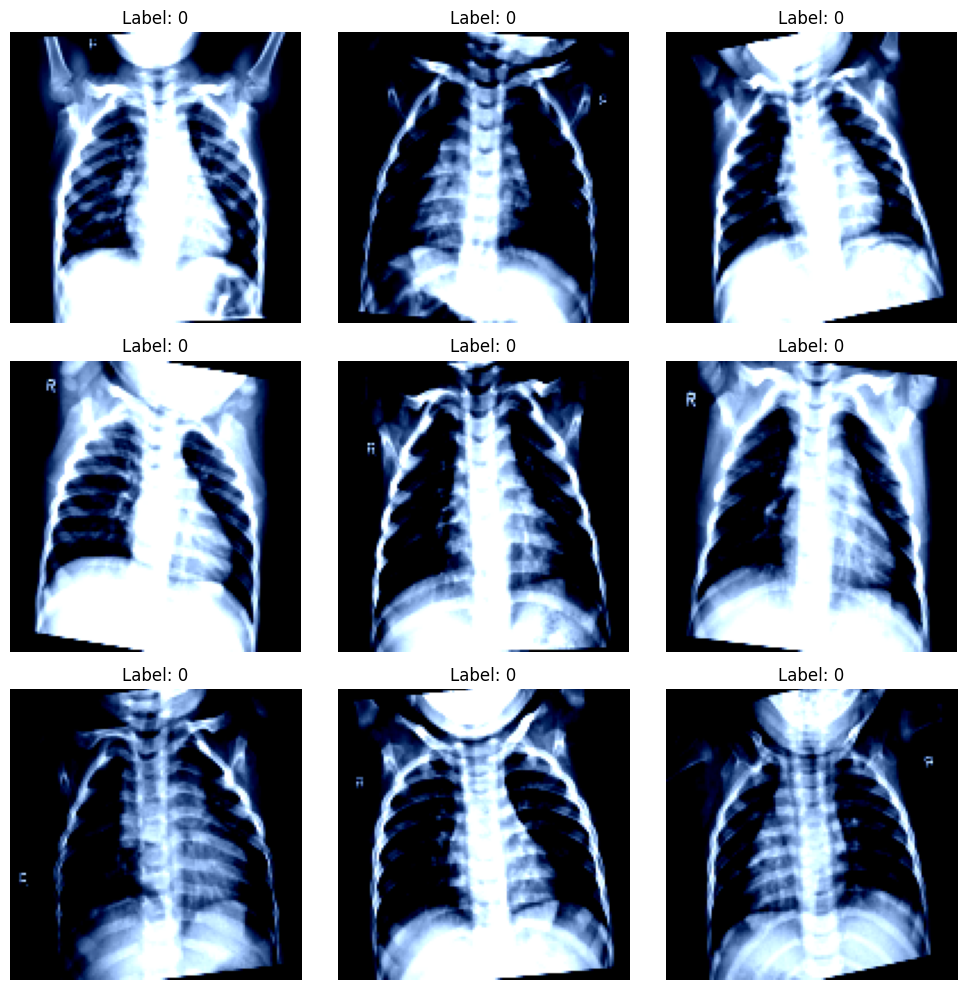

In [3]:
# Display a few sample images from the dataset
def visualize_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        image, label = dataset[i]
        plt.imshow(image.permute(1, 2, 0))  # Convert from CHW to HWC format
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Call the function with the training dataset
visualize_images(train_dataset)

In [4]:
# Assume each image corresponds to a patient in this metadata table
metadata = pd.DataFrame({
    "Patient_ID": np.arange(len(train_dataset)),
    "Age": np.random.randint(20, 80, size=len(train_dataset)),
    "Sex": np.random.choice(["M", "F"], size=len(train_dataset)),
    "Smoking_Status": np.random.choice(["Never", "Former", "Current"], size=len(train_dataset)),
    "Disease_Label": [label for _, label in train_dataset.samples]  # Labels from dataset
})

# Normalize and encode tabular data
metadata["Sex"] = metadata["Sex"].map({"M": 0, "F": 1})
metadata["Smoking_Status"] = metadata["Smoking_Status"].map({"Never": 0, "Former": 1, "Current": 2})
metadata_features = metadata[["Age", "Sex", "Smoking_Status"]].values
metadata_labels = metadata["Disease_Label"].values

# Split metadata into train and validation subsets
metadata_train, metadata_val, labels_train, labels_val = train_test_split(
    metadata_features, metadata_labels, test_size=0.2, random_state=42
)

In [5]:
# Display the first few rows of the metadata dataframe
def display_dataframe(df, num_rows=5):
    print("Sample Metadata:")
    print(df.head(num_rows))

# Call the function with the metadata dataframe
display_dataframe(metadata)

Sample Metadata:
   Patient_ID  Age  Sex  Smoking_Status  Disease_Label
0           0   56    1               1              0
1           1   71    1               1              0
2           2   55    1               1              0
3           3   39    1               0              0
4           4   39    0               2              0


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#fcab3a;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;color:white;text-align:center;">Create 3 Models (Feature Extractors): <ul style="font-family:Arial, sans-serif; font-size:16px; color:black;">
   <li>Client A: Image feature extractor, uses mobilenet_v2 pretrained head.</li>
   <li>Client B: Tabular feature extractor, simple neural net with linear layers and ReLU for non linearlity.</li>
   <li>Aggregator: Combines features from both clients, simple neural net with linear layers and ReLU for non linearlity.</li></ul></p></div>

In [6]:
# Client A: Image feature extractor
class ClientA(nn.Module):
    def __init__(self):
        super(ClientA, self).__init__()
        self.model = models.mobilenet_v2(pretrained=True)
        # Remove final layer for feature extraction
        self.model.classifier = nn.Identity()  
    
    def forward(self, x):
        return self.model(x)

# Client B: Tabular feature extractor
class ClientB(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super(ClientB, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
    
    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
client_a = ClientA().to(device)
client_b = ClientB(input_dim=3).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 143MB/s]


In [7]:
class Aggregator(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(Aggregator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

# Combine features from both clients
aggregator = Aggregator(input_dim=1280 + 32).to(device)  

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#8cf5a2;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;color:black;text-align:center;">MODEL(S) TRAINING</p></div>

In [8]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer_a = optim.Adam(client_a.parameters(), lr=0.001)
optimizer_b = optim.Adam(client_b.parameters(), lr=0.001)
optimizer_agg = optim.Adam(aggregator.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    client_a.train()
    client_b.train()
    aggregator.train()
    
    epoch_loss = 0
    for images, labels in train_loader:
        # Split images and metadata (simulated)
        batch_size = images.size(0)
        metadata_batch = torch.tensor(metadata_train[:batch_size], dtype=torch.float32).to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        # Forward pass on clients
        features_a = client_a(images.to(device))  # Image features
        features_b = client_b(metadata_batch)  # Metadata features
        
        # Concatenate features and pass to aggregator
        combined_features = torch.cat((features_a, features_b), dim=1)
        outputs = aggregator(combined_features)
        
        # Loss computation
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        
        # Backward pass
        optimizer_a.zero_grad()
        optimizer_b.zero_grad()
        optimizer_agg.zero_grad()
        loss.backward()
        
        optimizer_a.step()
        optimizer_b.step()
        optimizer_agg.step()
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/5, Loss: 0.1297
Epoch 2/5, Loss: 0.0950
Epoch 3/5, Loss: 0.0713
Epoch 4/5, Loss: 0.0622
Epoch 5/5, Loss: 0.0565


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#faff66;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;color:black;text-align:center;">MODEL(S) TESTING</p></div>

In [9]:
def evaluate_vfl(client_a, client_b, aggregator, dataloader, metadata, labels):
    client_a.eval()
    client_b.eval()
    aggregator.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels_batch in dataloader:
            batch_size = images.size(0)
            metadata_batch = torch.tensor(metadata[:batch_size], dtype=torch.float32).to(device)
            labels_batch = labels_batch.float().unsqueeze(1).to(device)
            
            features_a = client_a(images.to(device))
            features_b = client_b(metadata_batch)
            combined_features = torch.cat((features_a, features_b), dim=1)
            outputs = torch.sigmoid(aggregator(combined_features))
            predicted = (outputs > 0.5).float()
            
            correct += (predicted == labels_batch).sum().item()
            total += labels_batch.size(0)
    
    return correct / total

accuracy = evaluate_vfl(client_a, client_b, aggregator, val_loader, metadata_val, labels_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 81.25%
